In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from dateutil.parser import parse
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import skew
import os

In [25]:
df = pd.read_csv("/Users/georgepetropoulos/Desktop/DMT/ODI-2025.csv", sep = ';')
df.columns = df.columns.str.strip()

In [26]:
numeric_cols = ['How many students do you estimate there are in the room?','What is your stress level (0-100)?',
    'How many hours per week do you do sports (in whole hours)?','Give a random number']

In [27]:
number_words = {
    'zero': 0.0,
    'one': 1.0,
    'two': 2.0,
    'three': 3.0,
    'four': 4.0,
    'five': 5.0,
    'six': 6.0,
    'seven': 7.0,
    'eight': 8.0,
    'nine': 9.0,
    'ten': 10.0,
}

def parse_numeric_value(val): ## Attempts to parse a messy string into a float. Returns None if parsing fails. ##
    if not isinstance(val, str):
        return val

    val = val.strip().lower()
    if not val:
        return None

    if val in number_words:
        return number_words[val]

    # Check for range like "180-200"
    range_match = re.match(r'^(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)$', val)
    if range_match:
        low = float(range_match.group(1))
        high = float(range_match.group(2))
        return (low + high) / 2.0

    # Check for arithmetic expression like "20*5*5"
    expr_match = re.match(r'^[0-9\.\+\-\*/\s]+$', val)
    if expr_match:
        try:
            return float(eval(val))
        except:
            pass

    # Replace commas if it's likely a decimal comma
    val_decimal = val.replace(',', '.')

    # Extract numeric substring from text
    num_search = re.search(r'[+-]?\d+(\.\d+)?([eE][+-]?\d+)?', val_decimal)
    if num_search:
        num_str = num_search.group(0)
        try:
            return float(num_str)
        except:
            return None

    return None

In [28]:
def clean_bedtime(val):
    
    if not isinstance(val, str):
        return val
    val = val.strip().lower()
    
    if not val:
        return None

    if '-' in val:
        val = val.replace('-', ':')
        
    #Handle known invalid/placeholder values
    if val in ['-', 'idk', 'unknown', '/', 'not today', 'n/a', 'null', 'late', '', ' ']:
        return np.nan

    #Special-case 'midnight' to "00:00"
    if "midnight" in val:
        return "00:00"
   
    # Any exact "12", "12.0", "12.00", "12:00" to "00:00"
    if re.match(r'^12(\.0+|:0+)?$', val):
        return "00:00"
    
    # If user typed a time in the 7–11 range
    # but without "am"/"pm", treat it as ambiguous → return NaN.
    if re.match(r'^(?:7|8|9|10|11)(?:[:.]\d+)?$', val):
        return np.nan

    try:
        # Convert formats like "7h30m" to "7:30"
        if re.match(r'^\d{1,2}h\d{1,2}(m)?$', val):
            val = re.sub(r'h', ':', val)
            val = re.sub(r'm', '', val)

        #Decimal hour format like "7.5" to "07:30"
        if re.match(r'^\d+\.\d+$', val):
            hr_float = float(val)
            hr = int(hr_float)
            mins = int(round((hr_float - hr) * 60))
            return f"{hr:02}:{mins:02}"

        #Plain digits like "730" to "07:30", "1230" to "12:30"
        if re.match(r'^\d{3,4}$', val):
            if len(val) == 3:
                return f"0{val[0]}:{val[1:]}"
            else:
                return f"{val[:2]}:{val[2:]}"

        #Single or double digit to "7" → "07:00"
        if re.match(r'^\d{1,2}$', val):
            return f"{int(val):02}:00"

        #24-hour style "7:30", "07:30", "07:30:00" to "07:30"
        if re.match(r'^\d{1,2}:\d{2}(:\d{2})?$', val):
            parts = val.split(":")
            hr = int(parts[0])
            mn = int(parts[1])
            return f"{hr:02}:{mn:02}"

        #12-hour clock with AM/PM, e.g. "7am", "7:30 pm", "12am" to 24-hour
        match = re.search(r'(\d{1,2})[:.]?(\d{0,2})\s*(am|pm)', val)
        if match:
            hour = int(match.group(1))
            minute = int(match.group(2)) if match.group(2) else 0
            suffix = match.group(3)

            if suffix == "pm" and hour != 12:
                hour += 12
            elif suffix == "am" and hour == 12:
                hour = 0

            return f"{hour:02}:{minute:02}"

    except:
        return np.nan

    # If nothing matched, return NaN
    return np.nan

df['Bedtime_Cleaned_24h'] = df['Time you went to bed Yesterday'].apply(clean_bedtime)

In [29]:
##cleaning birthday data using multiple logics and appending back the final data back to the coloumn for cleaned dataset
def parse_birthday_extended(val):
    if not isinstance(val, str):
        return None

    val = val.strip().lower()
    invalids = ['-', 'x', 'idk', 'lol', 'unknown', 'not today', 'tomorrow', '/', 'none', 'undisclosed']
    if val in invalids:
        return None

    digits_only = re.sub(r'[^0-9]', '', val)

    ##handling 8-digit DDMMYYYY
    if len(digits_only) == 8:
        try:
            dt = datetime.strptime(digits_only, "%d%m%Y")
            if dt.year < 1950:
                return None
            return dt.strftime("%d-%m-%Y")
        except:
            pass

    ## handling 6-digit MMDDYY → DDMMYYYY
    if len(digits_only) == 6:
        try:
            mm = int(digits_only[:2])
            dd = int(digits_only[2:4])
            yy = int(digits_only[4:6])
            if mm >= 1 and mm <= 12 and dd >= 1 and dd <= 31:
                year = 2000 + yy if yy <= 30 else 1900 + yy
                dt = datetime(year, mm, dd)
                if dt.year < 1950:
                    return None
                return dt.strftime("%d-%m-%Y")
        except:
            return None

    ## checking the for presence of day, month, and full year before fuzzy parse
    has_day = bool(re.search(r'\b([1-9]|[12][0-9]|3[01])\b', val))
    has_month = bool(re.search(r'(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|\b0?[1-9]\b|\b1[0-2]\b)', val))
    has_year = bool(re.search(r'(19|20)\d{2}', val))

    if not (has_day and has_month and has_year):
        return None

    try:
        dt = parse(val, fuzzy=True, dayfirst=True)
        if dt.year < 1970:
            return None
        return dt.strftime("%d-%m-%Y")
    except:
        return None
df['When is your birthday (date)?'] = df['When is your birthday (date)?'].apply(parse_birthday_extended)

In [30]:
def log_transform(x):
    """
    Signed log transform:
    - 0 stays 0
    - Positive x -> log1p(x)
    - Negative x -> -log1p(|x|)
    """
    if pd.isnull(x):
        return np.nan
    if x == 0:
        return 0.0
    # sign(x) * ln(1 + |x|)
    return np.sign(x) * np.log1p(abs(x))

def clean_iqr(series, parse_fn, iqr_factor=1.5, extreme="no"):
    """
    1) Parses each element in series using parse_fn, converting to float.
    2) If extreme == "yes", applies a signed log transform on the parsed values.
    3) Computes Q1, Q3, and IQR (Q3 - Q1) on the resulting data.
    4) Flags outliers (< Q1 - iqr_factor*IQR or > Q3 + iqr_factor*IQR)
       and sets them to NaN.
    """

    #Parse raw values
    parsed = series.apply(parse_fn).astype(float)

    #If extreme == "yes", apply signed log transform
    if extreme.lower() == "yes":
        parsed = parsed.apply(log_transform)

    #Compute IQR on (optionally) transformed data
    q1 = parsed.quantile(0.25)
    q3 = parsed.quantile(0.75)
    iqr = q3 - q1

    if iqr == 0 or pd.isnull(iqr):
        #If there's no variation, just return as is
        return parsed

    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    #Mark out-of-bounds values as NaN
    parsed[(parsed < lower_bound) | (parsed > upper_bound)] = np.nan

    return parsed

In [31]:
def clean_with_clipping(series, lower = 0, upper = 100):
    """
    Parse into numeric and clip to [0, 100].
    """
    parsed = series.apply(parse_numeric_value).astype(float)
    return parsed.clip(lower = lower , upper=upper)

In [32]:
def clean_students_in_room(series):
    """
    Parse into numeric; treat negative as NaN.
    """
    parsed = series.apply(parse_numeric_value).astype(float)
    parsed.loc[parsed < 0] = np.nan
    return parsed

In [33]:
# Outlier Cleaning
df.iloc[:, 9] = df.iloc[:, 9].apply(parse_numeric_value)
df.iloc[:, 10] = df.iloc[:, 10].apply(parse_numeric_value)
df.iloc[:, 11] = df.iloc[:, 11].apply(parse_numeric_value)
df.iloc[:, 12] = df.iloc[:, 12].apply(parse_numeric_value)
df.iloc[:, 9] = clean_iqr(df.iloc[:, 9], parse_numeric_value, iqr_factor = 1.5, extreme = "no")
df.iloc[:, 9] = clean_students_in_room(df.iloc[:, 9])
df.iloc[:, 10] = clean_with_clipping(df.iloc[:, 10], lower = 0, upper = 100)
df.iloc[:, 11] = clean_with_clipping(df.iloc[:, 11], lower = 0, upper = 40)
df.iloc[:, 12] = clean_iqr(df.iloc[:, 12], parse_numeric_value, iqr_factor = 3.5, extreme = "yes")

In [34]:
## 
def is_missing(value):
    """
    Framing the logic to decide if the value should be considered missing: #1. Empty or known placeholders, #2. No letters at all.
    #3. More than 3 'invalid' characters (anything not a-z, A-Z, '!', or '?'
    """
    val = str(value).strip()

    placeholders = ["-", "n/a", "none", "()", "nan"]
    if val == "" or val.lower() in placeholders:
        return True

    if not re.search(r"[a-zA-Z]", val):
        return True

    invalid_chars = re.findall(r"[^a-zA-Z!\?\.\:\(\)\s]", val)
    if len(invalid_chars) > 3:
        return True

    return False

df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: np.nan if is_missing(x) else x)
df.iloc[:, 14] = df.iloc[:, 14].apply(lambda x: np.nan if is_missing(x) else x)
df.iloc[:, 15] = df.iloc[:, 15].apply(lambda x: np.nan if is_missing(x) else x)

In [35]:
# # output_filename = "ODI_2025_Cleaned_Ver1.csv"
# output_path = os.path.join(os.getcwd(), output_filename)

# df.to_csv(output_path, index=False)
# print(f"File saved successfully at: {output_path}")

Missingness heatmap for categorical columns:


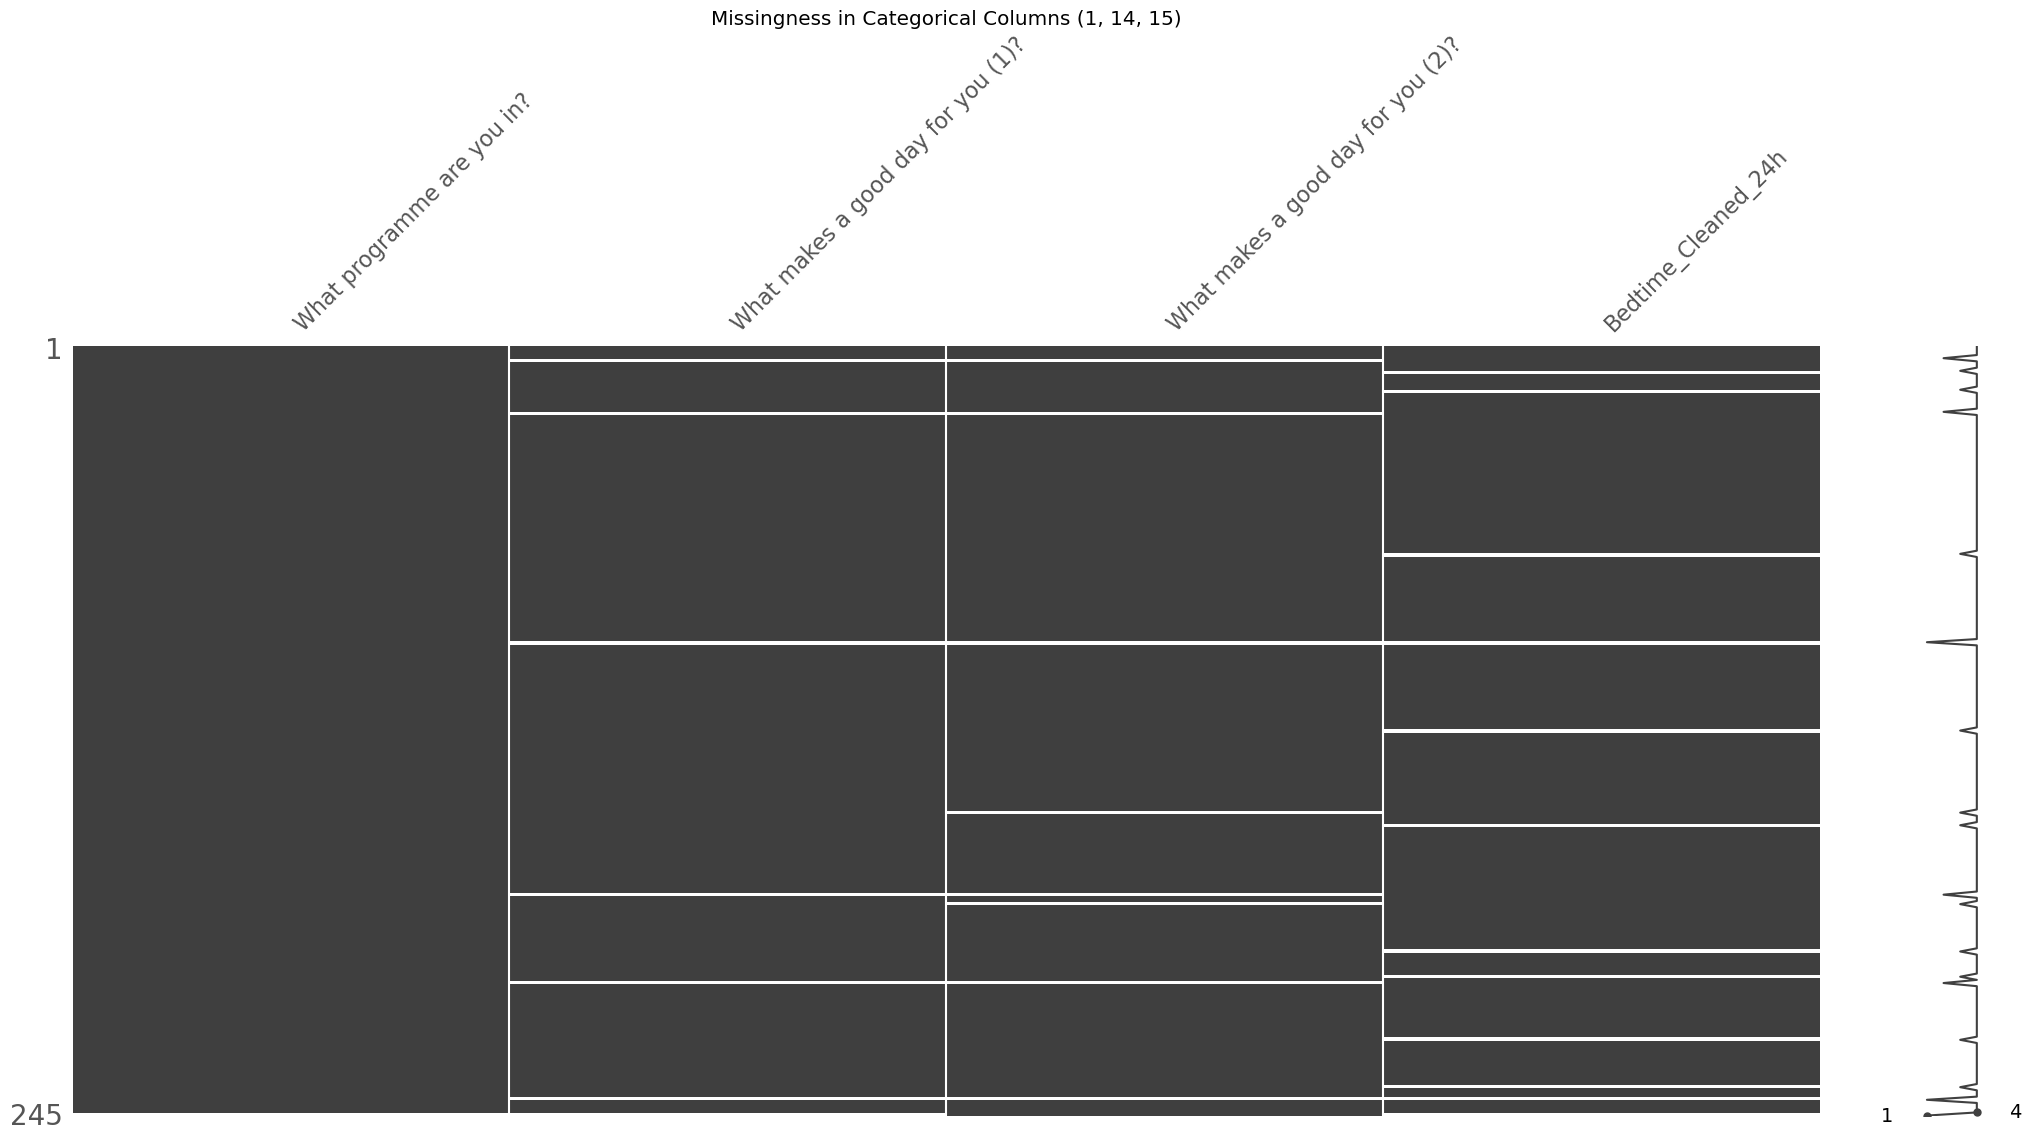

Missingness heatmap for numeric columns:


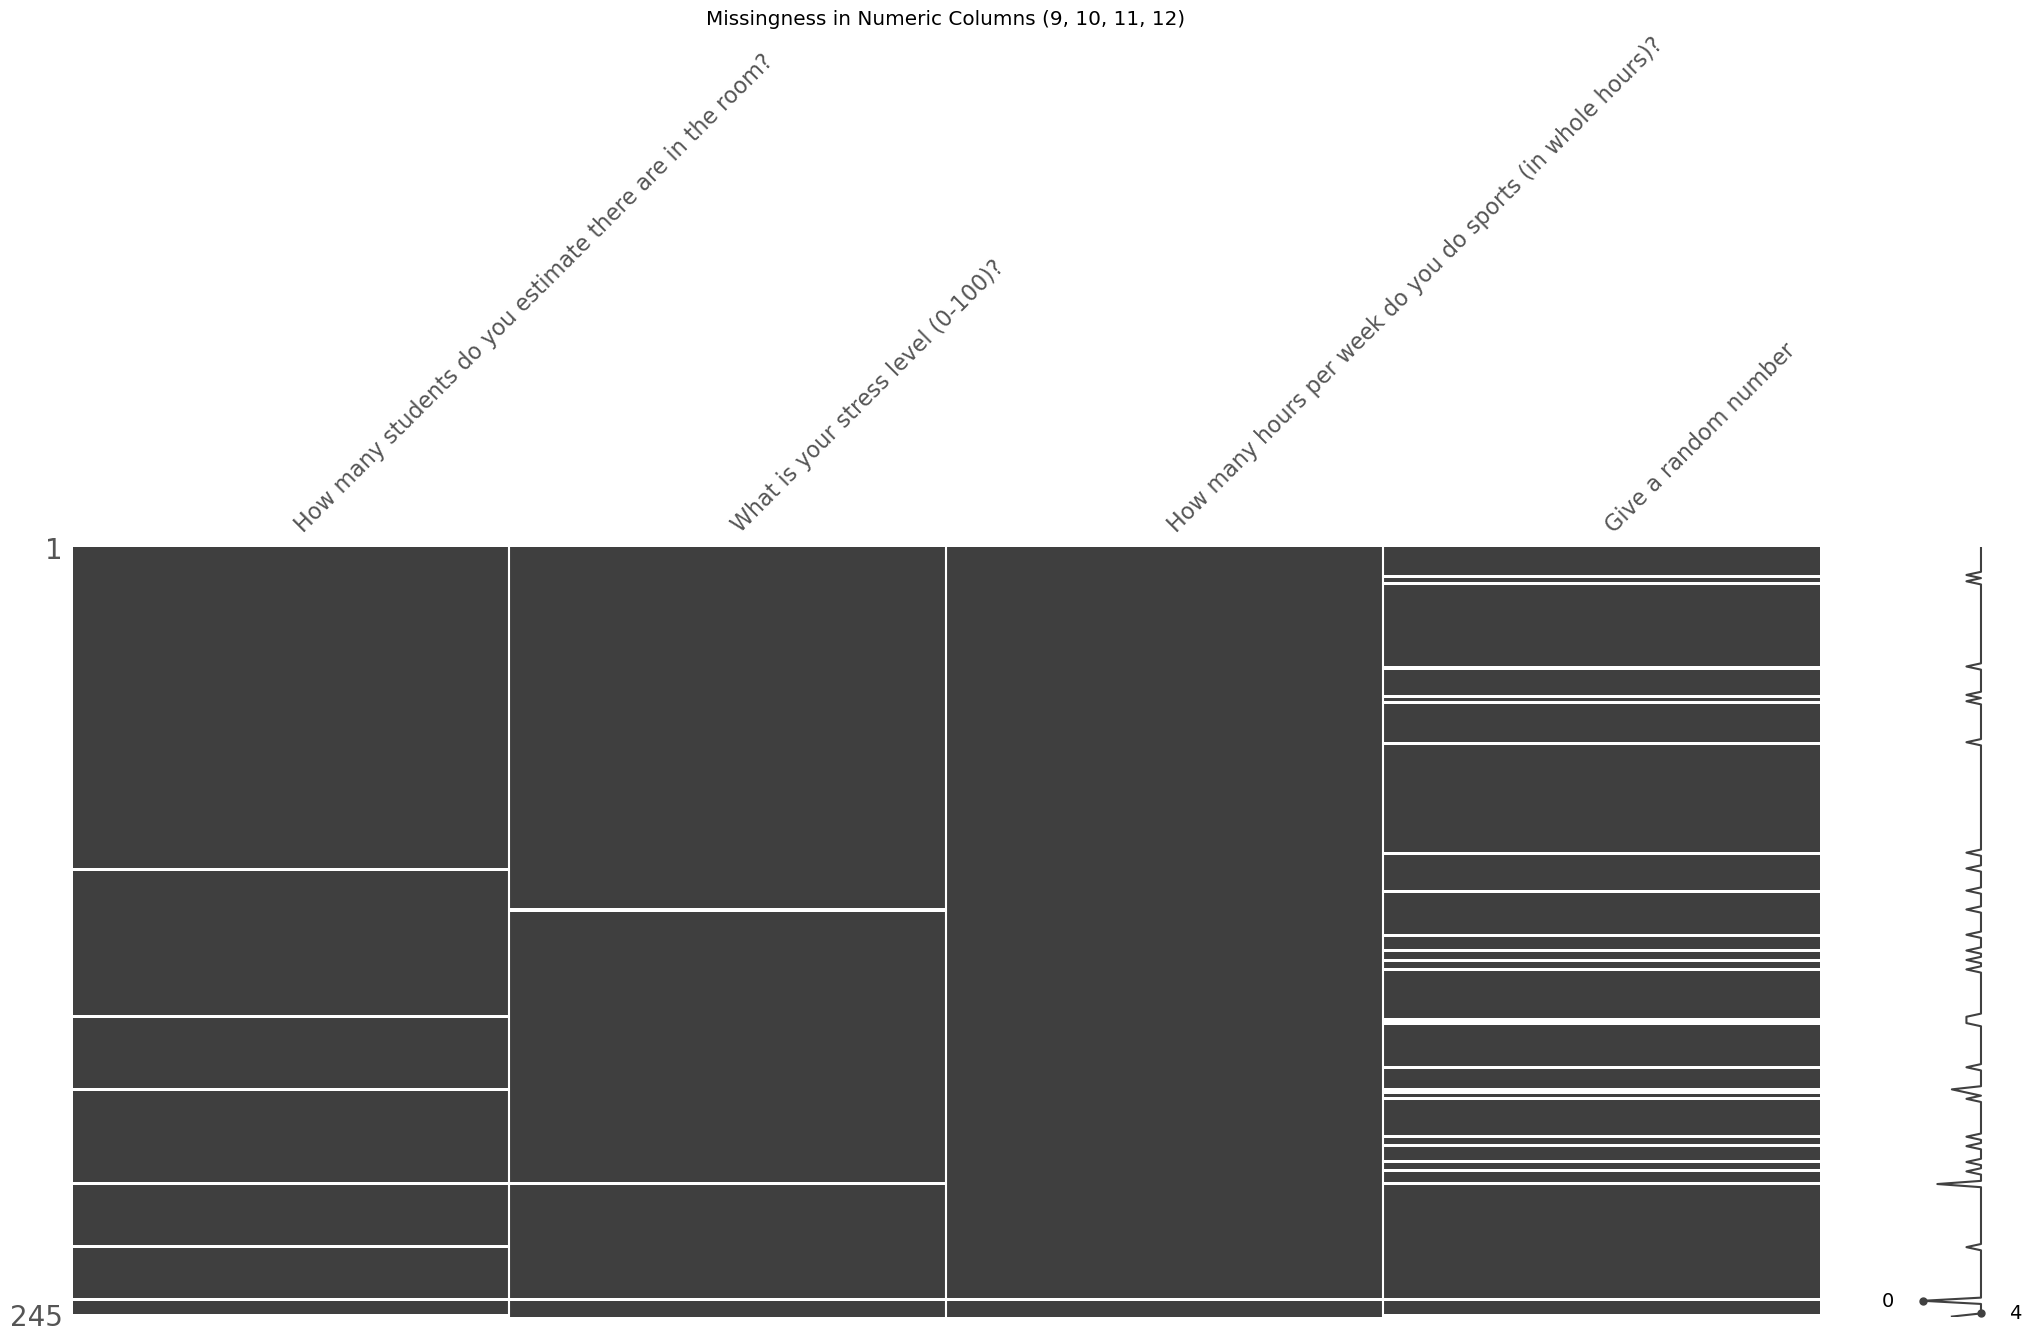

Missing value correlation heatmap:


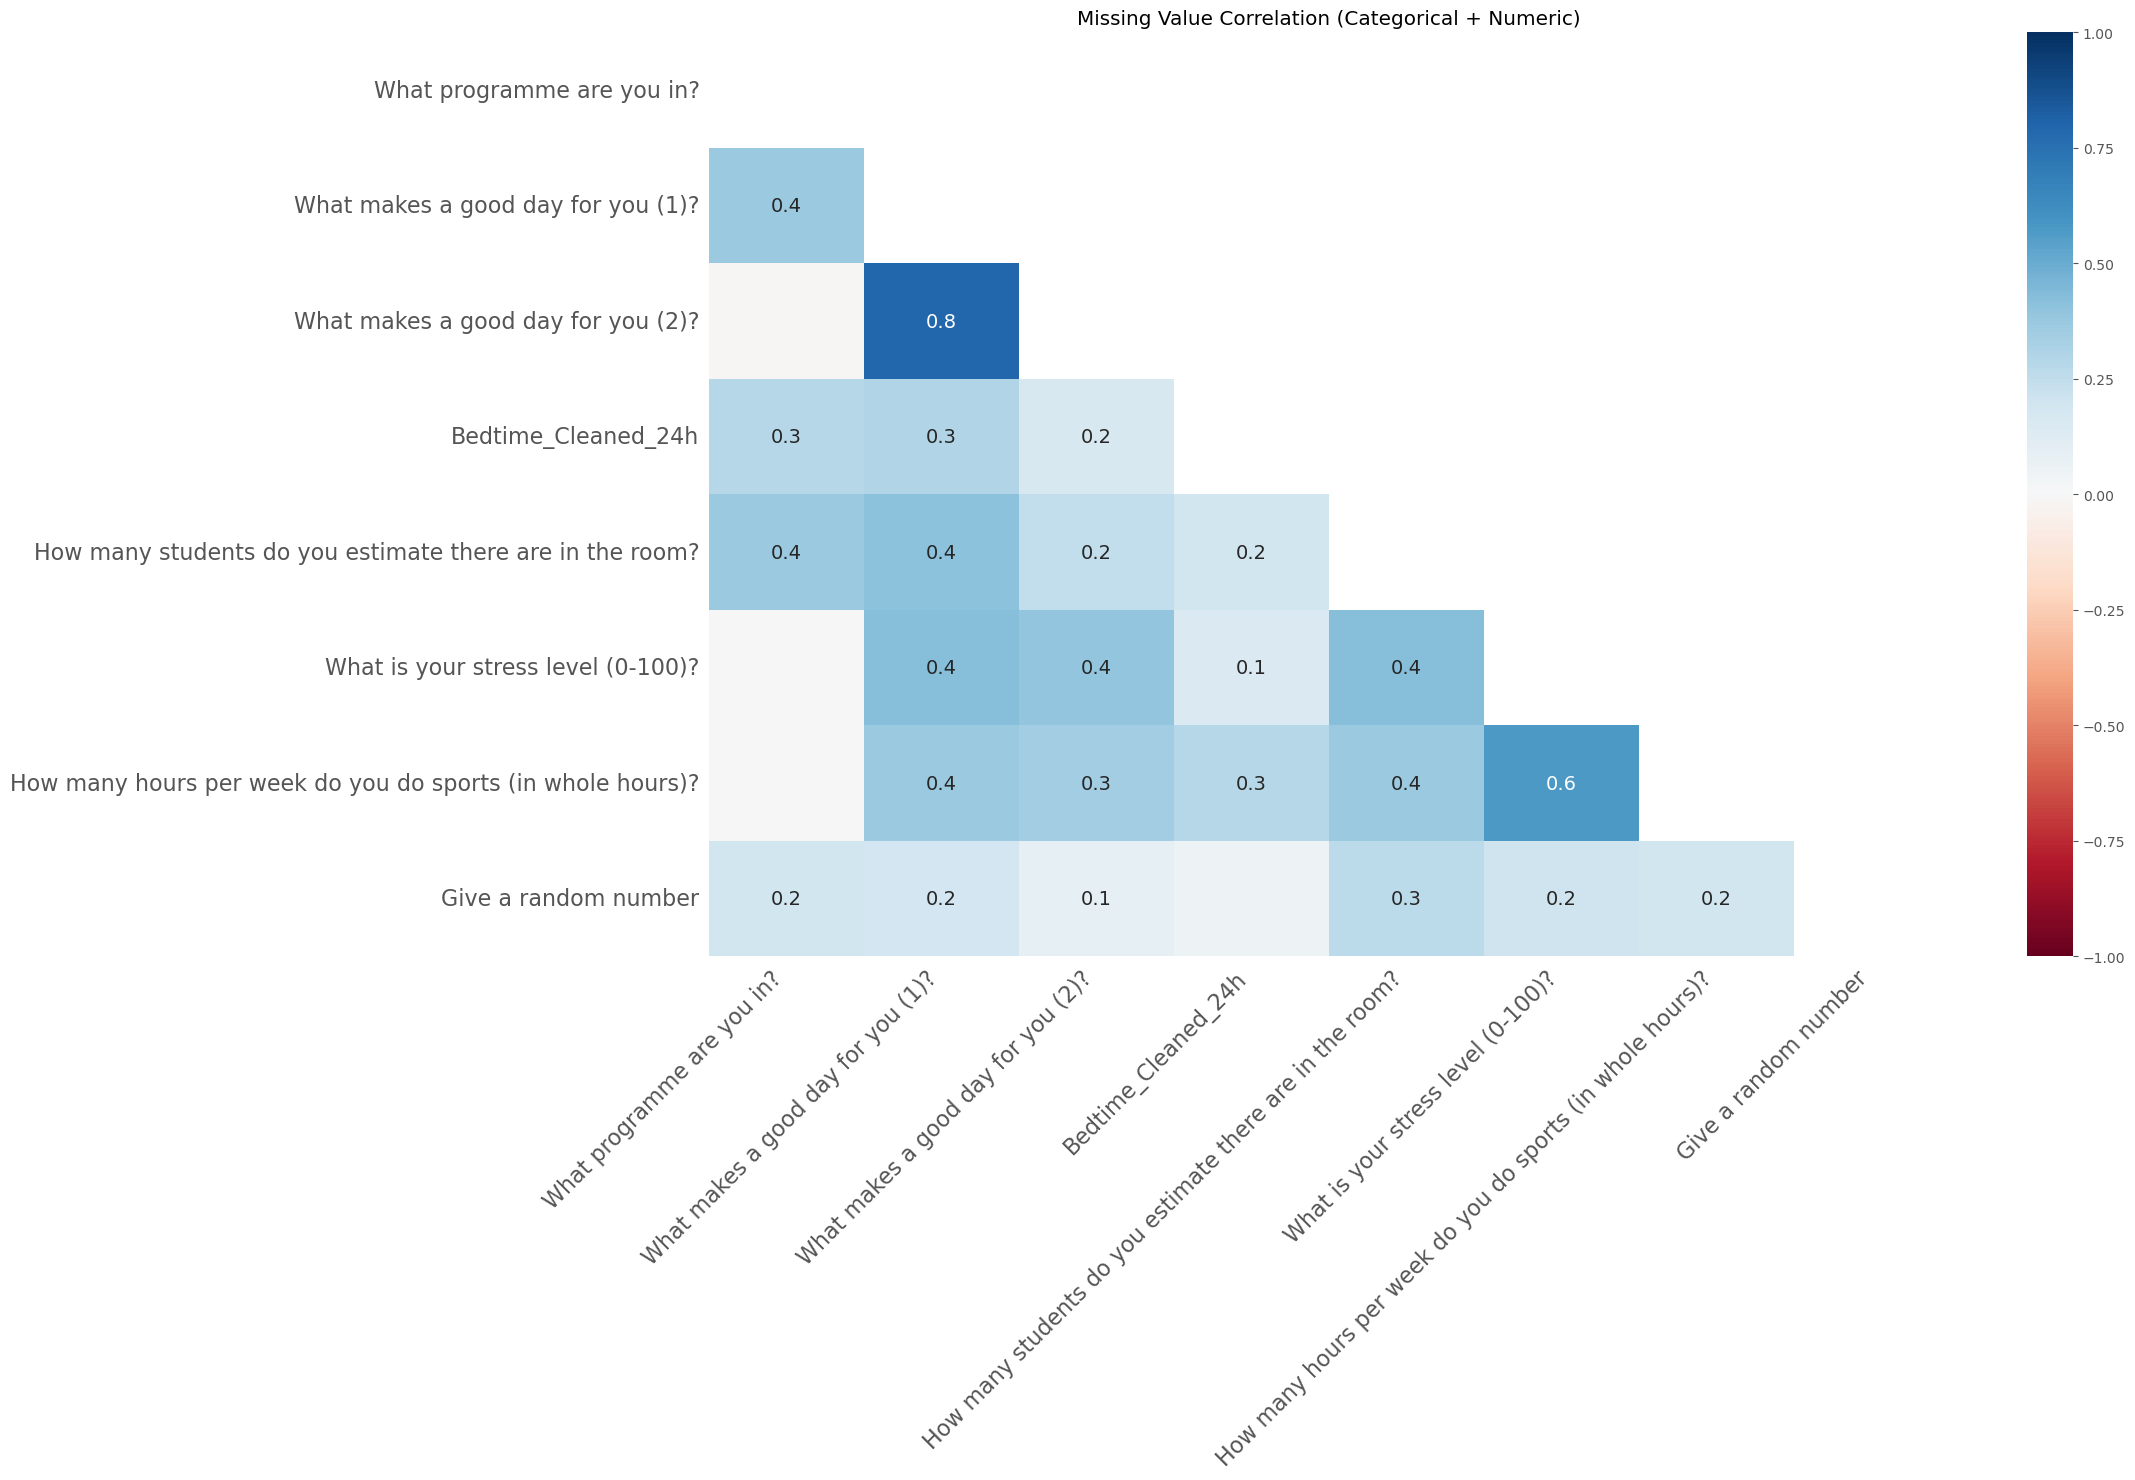

In [36]:
import missingno as msno

plt.style.use('ggplot')

categorical_cols = [df.columns[1], df.columns[14], df.columns[15], df.columns[16]]
print("Missingness heatmap for categorical columns:")
msno.matrix(df[categorical_cols])
plt.title("Missingness in Categorical Columns (1, 14, 15)")
plt.show()

numeric_cols = [df.columns[9], df.columns[10], df.columns[11], df.columns[12]]
print("Missingness heatmap for numeric columns:")
msno.matrix(df[numeric_cols])
plt.title("Missingness in Numeric Columns (9, 10, 11, 12)")
plt.show()

print("Missing value correlation heatmap:")
msno.heatmap(df[categorical_cols + numeric_cols])
plt.title("Missing Value Correlation (Categorical + Numeric)")
plt.show()

In [37]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [38]:
def clean_numeric_mean_median(df, numeric_cols, skew_threshold=1.0):
    """
    Imputes missing numeric values by either mean or median based on skew.
    """
    imputation_log = {}

    for col in numeric_cols:
        # Ensure the column is numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        col_skew = df[col].skew(skipna=True)
        if abs(col_skew) > skew_threshold:
            impute_value = df[col].median(skipna=True)
            method_used = "median"
        else:
            impute_value = df[col].mean(skipna=True)
            method_used = "mean"

        df[col] = df[col].fillna(round(impute_value, 2)).astype(float)

        imputation_log[col] = method_used

    return df, imputation_log

def impute_categorical_series(series, method="unknown"):
    if method == "unknown":
        return series.fillna("unknown")
    elif method == "mode":
        mode_value = series.mode(dropna=True)
        if not mode_value.empty:
            return series.fillna(mode_value[0])
        else:
            return series.fillna("unknown")
    else:
        raise ValueError("method must be either 'unknown' or 'mode'.")


In [39]:
df, numeric_log = clean_numeric_mean_median(df, numeric_cols, skew_threshold=1.0)
df["What programme are you in?"] = impute_categorical_series(df["What programme are you in?"], method="mode")
df["What makes a good day for you (1)?"] = impute_categorical_series(df["What makes a good day for you (1)?"], method="unknown")
df["What makes a good day for you (2)?"] = impute_categorical_series(df["What makes a good day for you (2)?"], method="unknown")
df["Bedtime_Cleaned_24h"] = impute_categorical_series(df["Bedtime_Cleaned_24h"], method="unknown")

In [40]:
# output_filename = "ODI_2025_Cleaned_Ver3.csv"
# output_path = os.path.join(os.getcwd(), output_filename)

# df.to_csv(output_path, index=False)
# print(f"File saved successfully at: {output_path}")

In [41]:
## Feature Engineering ##

#Applying log(1 + x) transformation to handle skewness in numeric data] ##
def log_transform(series): 
    return np.log1p(series)

#Standardizes the series using Z-score normalization ##
def zscore_normalize(series): 
    mean = series.mean()
    std = series.std()
    return (series - mean) / std

#Bins stress level into 0 or 1: 0 = low/moderate stress, 1 = high stress ##
def binary_stress_level(series, threshold=60): 
    return (series > threshold).astype(int)

#Creates a ratio of stress to physical activity ##
def stress_to_sports_ratio(stress_series, sports_series): 
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = stress_series / (sports_series + 1e-5)
        ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
        return ratio

#Discretizes sports hours into buckets: 0 = none, 1 = low (1–3 hrs), 2 = medium (4–8), 3 = high (>8) ##
def categorize_sports_hours(series): 
    return pd.cut(series, bins=[-1, 0, 3, 8, 100], labels=[0, 1, 2, 3]).astype(int)

#Creating a new feature as the interaction of stress level and random number ##
def interaction_feature(stress_series, random_series): 
    return stress_series * random_series

#Flagging: Based on 'Time you went to bed Yesterday'(text).Returns 1 if bedtime > 12:00 AM, else 0 ##
def is_night_owl(series): 
    def extract_hour(val):
        try:
            if pd.isna(val) or val == 'unknown':
                return np.nan
            return int(str(val).split(":")[0])
        except:
            return np.nan

    hours = series.apply(extract_hour)
    return (hours >= 0) & (hours <= 5)

#Now need to applyback the night owl flag ##
df['Is_Night_Owl'] = is_night_owl(df['Bedtime_Cleaned_24h'])

#Applying transformations for the data columns ##
df['Log_Students_Estimate'] = log_transform(df['How many students do you estimate there are in the room?'])
df['Stress_High_Flag'] = binary_stress_level(df['What is your stress level (0-100)?'])
df['Stress_Random_Interaction'] = interaction_feature(df['What is your stress level (0-100)?'],df['Give a random number'])
df['Zscore_Stress'] = zscore_normalize(df['What is your stress level (0-100)?'])
df['Sports_Hours_Bin'] = categorize_sports_hours(df['How many hours per week do you do sports (in whole hours)?'])
df['Stress_to_Sports_Ratio'] = stress_to_sports_ratio(df['What is your stress level (0-100)?'],
                                                      df['How many hours per week do you do sports (in whole hours)?'])
df['Is_Night_Owl'] = is_night_owl(df['Bedtime_Cleaned_24h'])

In [42]:
# output_filename = "ODI_2025_Cleaned_Ver4.csv"
# output_path = os.path.join(os.getcwd(), output_filename)

# df.to_csv(output_path, index=False)
# print(f"File saved successfully at: {output_path}")

In [47]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
from scipy.stats import randint, uniform

df['Is_Night_Owl'] = df['Is_Night_Owl'].astype(object)
df['Stress_High_Flag'] = df['Stress_High_Flag'].astype(object)
df['Stress_to_Sports_Ratio'] = df['Stress_to_Sports_Ratio'].astype(float)

columns_to_use = [
    'Have you taken a course on machine learning?',
    'Have you taken a course on information retrieval?',
    'Have you taken a course on statistics?',
    'Have you taken a course on databases?',
    'What is your gender?',
    'I have used ChatGPT to help me with some of my study assignments',
    'What is your stress level (0-100)?',  # target
    'How many hours per week do you do sports (in whole hours)?',
    'Is_Night_Owl',
    'Stress_High_Flag',
    'Stress_to_Sports_Ratio'
]
print(df.dtypes)

Timestamp                                                            object
What programme are you in?                                           object
Have you taken a course on machine learning?                         object
Have you taken a course on information retrieval?                    object
Have you taken a course on statistics?                               object
Have you taken a course on databases?                                object
What is your gender?                                                 object
I have used ChatGPT to help me with some of my study assignments     object
When is your birthday (date)?                                        object
How many students do you estimate there are in the room?            float64
What is your stress level (0-100)?                                  float64
How many hours per week do you do sports (in whole hours)?          float64
Give a random number                                                float64
Time you wen

In [49]:
df_sub = df[columns_to_use].copy()

#Target and features
y = df_sub['What is your stress level (0-100)?'].astype(float)
X = df_sub.drop(columns=['What is your stress level (0-100)?'])

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Random Forest pipeline (for categorical encoding + regression)
numeric_cols1 = ['How many hours per week do you do sports (in whole hours)?', 'Stress_to_Sports_Ratio']
categorical_cols = [
    'Have you taken a course on information retrieval?',
    'Have you taken a course on statistics?',
    'Have you taken a course on databases?',
    'Have you taken a course on machine learning?',
    'What is your gender?',
    'I have used ChatGPT to help me with some of my study assignments', 
    'Is_Night_Owl', 
    'Stress_High_Flag' 
]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ("num", "passthrough", numeric_cols1)
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf_reg", RandomForestRegressor(random_state=42))
])

param_dist_rf = {
    "rf_reg__n_estimators": randint(50, 301),
    "rf_reg__max_depth": [None, 5, 10, 15, 20]
}

random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_rf.fit(X_train, y_train)
print("Best Random Forest Params")
print(random_search_rf.best_params_)
print("Best CV R^2:", random_search_rf.best_score_)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Test Results:")
print(" R^2:", r2_rf)

rf_results = pd.DataFrame(random_search_rf.cv_results_)

#CatBoost: tune iterations + learning_rate
cat_features = [
    'Have you taken a course on information retrieval?',
    'Have you taken a course on statistics?',
    'Have you taken a course on databases?',
    'Have you taken a course on machine learning?',
    'What is your gender?',
    'I have used ChatGPT to help me with some of my study assignments',
    'Is_Night_Owl',
    'Stress_High_Flag'
]
cat_reg = CatBoostRegressor(
    cat_features=cat_features,
    random_seed=42,
    verbose=0
)

param_dist_cat = {
    "iterations": randint(500, 2001),
    "learning_rate": uniform(0.01, 0.19)
}

random_search_cat = RandomizedSearchCV(
    cat_reg,
    param_distributions=param_dist_cat,
    n_iter=10,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_cat.fit(X_train, y_train)
print("Best CatBoost Params")
print(random_search_cat.best_params_)
print("Best CV R^2:", random_search_cat.best_score_)

best_cat = random_search_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
print("\nCatBoost Test Results:")
print(" R^2:", r2_cat)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest Params
{'rf_reg__max_depth': 10, 'rf_reg__n_estimators': 252}
Best CV R^2: 0.9080608446230505

Random Forest Test Results:
 R^2: 0.9016222035089677
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CatBoost Params
{'iterations': 1544, 'learning_rate': 0.039643541684062936}
Best CV R^2: 0.9131411936444866

CatBoost Test Results:
 R^2: 0.9218125169429692


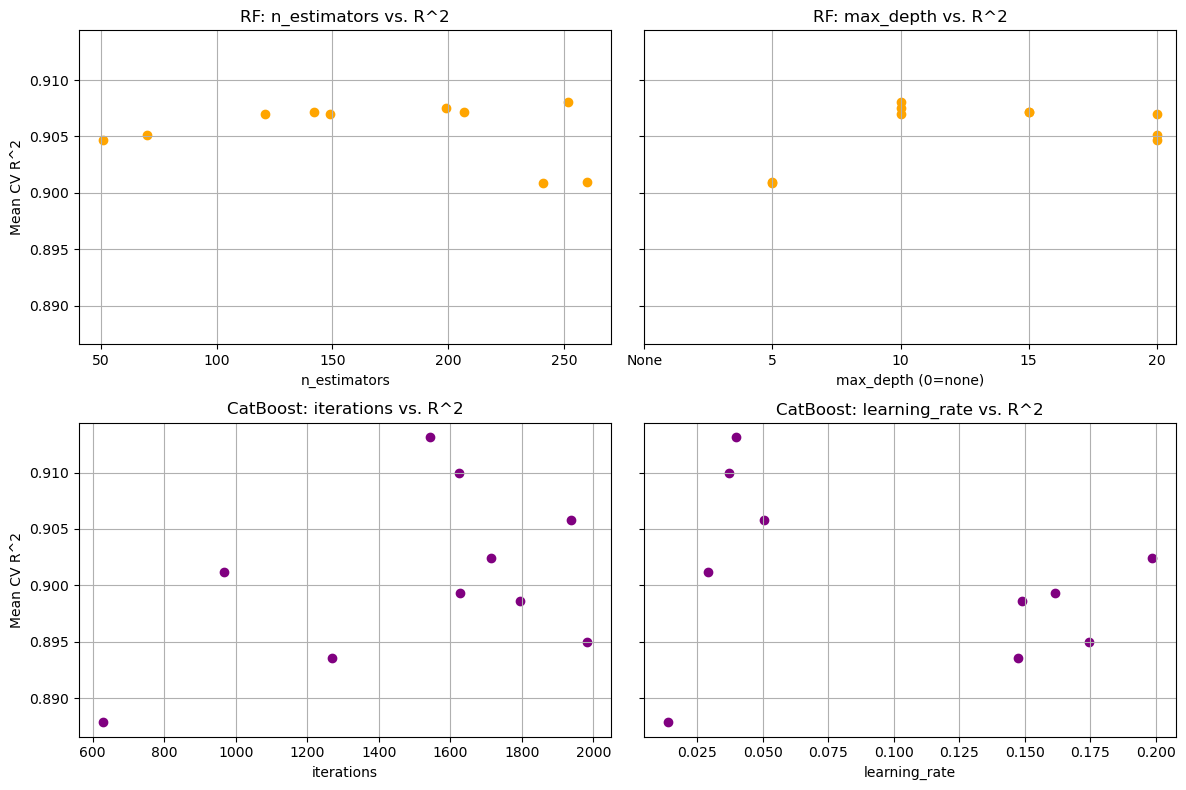

In [50]:
cat_results = pd.DataFrame(random_search_cat.cv_results_)

plt.style.use('default')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)

axes[0,0].scatter(
    rf_results["param_rf_reg__n_estimators"],
    rf_results["mean_test_score"],
    color='orange',
    marker='o'
)
axes[0,0].set_title("RF: n_estimators vs. R^2")
axes[0,0].set_xlabel("n_estimators")
axes[0,0].set_ylabel("Mean CV R^2")
axes[0,0].grid(True)

def depth_to_numeric(d):
    return 0 if d is None else d

rf_results["depth_numeric"] = rf_results["param_rf_reg__max_depth"].apply(depth_to_numeric)

axes[0,1].scatter(
    rf_results["depth_numeric"],
    rf_results["mean_test_score"],
    color='orange',
    marker='o'
)
axes[0,1].set_title("RF: max_depth vs. R^2")
axes[0,1].set_xlabel("max_depth (0=none)")
axes[0,1].grid(True)
axes[0,1].set_xticks([0, 5, 10, 15, 20])
axes[0,1].set_xticklabels(["None","5","10","15","20"])

axes[1,0].scatter(
    cat_results["param_iterations"],
    cat_results["mean_test_score"],
    color='purple',
    marker='o'
)
axes[1,0].set_title("CatBoost: iterations vs. R^2")
axes[1,0].set_xlabel("iterations")
axes[1,0].set_ylabel("Mean CV R^2")
axes[1,0].grid(True)

axes[1,1].scatter(
    cat_results["param_learning_rate"],
    cat_results["mean_test_score"],
    color='purple',
    marker='o'
)
axes[1,1].set_title("CatBoost: learning_rate vs. R^2")
axes[1,1].set_xlabel("learning_rate")
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [51]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n Random Forest Test Results:")
print(f" MSE: {mse_rf:}")
print(f" MAE: {mae_rf:}")

mse_cat = mean_squared_error(y_test, y_pred_cat)
mae_cat = mean_absolute_error(y_test, y_pred_cat)

print("\n CatBoost Test Results:")
print(f" MSE: {mse_cat:}")
print(f" MAE: {mae_cat:}")


 Random Forest Test Results:
 MSE: 98.1762879516142
 MAE: 7.774702831159949

 CatBoost Test Results:
 MSE: 78.02733060318886
 MAE: 6.955195707328659
